In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten
from tensorflow.keras.applications import EfficientNetV2M

2024-04-29 15:50:02.408071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 15:50:02.408164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 15:50:02.572201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Import Libraries**

In [2]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Flatten,MaxPooling2D,Conv2D,Activation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import os
import glob

In [3]:
import numpy as np
import pandas as pd
import os
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [5]:
encoder=OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5]])

OneHotEncoder()

# **Read Dataset**


In [6]:
image_data='/kaggle/input/emotion-recognition-dataset/dataset'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,Surprise
1,Angry
2,Neutral
3,Sad
4,Happy
5,Ahegao


In [7]:
files_l = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files_l)
labels_l = [os.path.dirname(i).split("/")[-1] for i in files_l]
data_l = zip(files_l, labels_l)

In [8]:
dataframe_l = pd.DataFrame(data_l, columns = ["Image", "Label"])

In [9]:
print(dataframe_l )

                                                   Image     Label
0      /kaggle/input/emotion-recognition-dataset/data...    Ahegao
1      /kaggle/input/emotion-recognition-dataset/data...       Sad
2      /kaggle/input/emotion-recognition-dataset/data...       Sad
3      /kaggle/input/emotion-recognition-dataset/data...       Sad
4      /kaggle/input/emotion-recognition-dataset/data...     Happy
...                                                  ...       ...
15448  /kaggle/input/emotion-recognition-dataset/data...  Surprise
15449  /kaggle/input/emotion-recognition-dataset/data...     Happy
15450  /kaggle/input/emotion-recognition-dataset/data...     Happy
15451  /kaggle/input/emotion-recognition-dataset/data...     Happy
15452  /kaggle/input/emotion-recognition-dataset/data...       Sad

[15453 rows x 2 columns]


Print the shape of image and display the image

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
# Load the image
image_path = "/kaggle/input/emotion-recognition-dataset/dataset/Ahegao/cropped_emotions.16023~ahegao.png"

image = Image.open(image_path)

# Print the size of the image
print("Image size:", image.size)


Image size: (264, 382)


# Count of images in each labels

In [11]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/input/emotion-recognition-dataset/dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Define an empty dictionary to store the counts of images for each class
class_counts = {}
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Surprise: 1234 images
Angry: 1313 images
Neutral: 4027 images
Sad: 3934 images
Happy: 3740 images
Ahegao: 1205 images
Total images: 15453


# **Visualization**

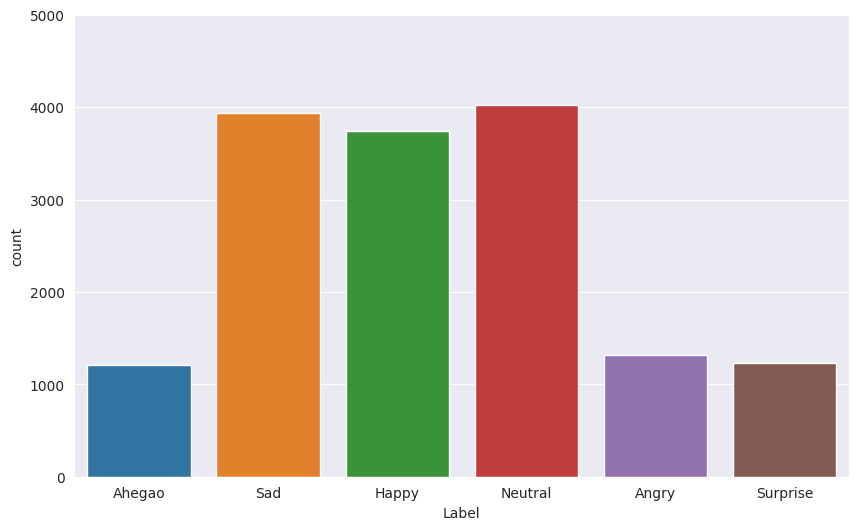

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=dataframe_l ["Label"])

# Get the counts for each class
class_counts = dataframe_l ["Label"].value_counts()
# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Limit y-axis range up to 6000
plt.ylim(0, 5000)

# Show plot
plt.show()


# Data Preprocessing

### Data Augmentation

Define Image parameters

In [13]:
image_data = '/kaggle/input/emotion-recognition-dataset/dataset'
train_data_dir = image_data
train_data_dir = image_data
batch_size = 64
target_size = (224, 224)
validation_split= 0.2

Define augmentation parameters


In [14]:
augmentation_params = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Function to count images in each class


In [15]:
def count_images(class_name):
    class_path = os.path.join(train_data_dir, class_name)
    return len(os.listdir(class_path))

Determine the classes to augment

In [16]:
classes_to_augment = ['Neutral','Sad','Happy','Ahegao', 'Angry', 'Surprise']
target_count = 4500

Define a writable directory for saving augmented images


In [17]:
output_dir = '/kaggle/working/augmented_images'

Perform data augmentation

In [18]:
for class_name in classes_to_augment:
    current_count = count_images(class_name)
    if current_count < target_count:
        augment_count = target_count - current_count
        augment_dir = os.path.join(output_dir, class_name)  # Save augmented images to a new directory
        os.makedirs(augment_dir, exist_ok=True)  # Create the directory if it doesn't exist
        augment_datagen = ImageDataGenerator(**augmentation_params)
        augment_generator = augment_datagen.flow_from_directory(
            train_data_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            classes=[class_name],
            save_to_dir=augment_dir,
            save_prefix='augmented',
            save_format='png'
        )
        # Generate augmented images until the target count is reached
        i = 0
        for batch in augment_generator:
            i += 1
            if i >= augment_count / batch_size:
                break

Found 4027 images belonging to 1 classes.
Found 3934 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 1205 images belonging to 1 classes.
Found 1313 images belonging to 1 classes.
Found 1234 images belonging to 1 classes.


### Count of augmented images

In [19]:
# Define the directory containing the dataset
dataset_dir = '/kaggle/working/augmented_images'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(dataset_dir, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")


Neutral: 512 images
Sad: 576 images
Happy: 768 images
Angry: 3138 images
Surprise: 3236 images
Ahegao: 3306 images
Total images: 11536


## Combine Original images and Augmented images

List all directories 

In [20]:
import os
import shutil

# Define paths
original_data_path ='/kaggle/input/emotion-recognition-dataset/dataset'
augmented_data_path = '/kaggle/working/augmented_images'
new_data_path = '/kaggle/working/merged_dataset'

# Get the list of classes
classes = os.listdir(original_data_path)
classes

['Surprise', 'Angry', 'Neutral', 'Sad', 'Happy', 'Ahegao']

Merge Data

In [21]:
# Create directories for each class in the new data path
for class_name in classes:
    os.makedirs(os.path.join(new_data_path, class_name), exist_ok=True)

# Copy images from the original data path to the new data path
for class_name in classes:
    original_class_path = os.path.join(original_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(original_class_path):
        shutil.copy(os.path.join(original_class_path, filename), os.path.join(new_class_path, filename))

# Copy images from the augmented data path to the new data path
for class_name in classes:
    augmented_class_path = os.path.join(augmented_data_path, class_name)
    new_class_path = os.path.join(new_data_path, class_name)
    for filename in os.listdir(augmented_class_path):
        shutil.copy(os.path.join(augmented_class_path, filename), os.path.join(new_class_path, filename))

print("Data merge complete.")


Data merge complete.


### Count of Combined images

In [22]:
# Define the directory containing the dataset
merged_dataset = '/kaggle/working/merged_dataset'
# List all directories (which represent classes)
class_directories = [d for d in os.listdir(merged_dataset) if os.path.isdir(os.path.join(merged_dataset, d))]

# Iterate through each class directory and count the number of files
total_images = 0
for class_dir in class_directories:
    class_path = os.path.join(merged_dataset, class_dir)
    file_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
    class_counts[class_dir] = file_count
    total_images += file_count

# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Print the total number of images
print(f"Total images: {total_images}")

Neutral: 4539 images
Sad: 4510 images
Happy: 4508 images
Angry: 4451 images
Surprise: 4470 images
Ahegao: 4511 images
Total images: 26989


Print the shape of augmented image and display the augmented image

image_path1 = "/kaggle/working/augmented_images/Ahegao/augmented_102_1413444.png"
image1 = Image.open(image_path1)
print("Image size:", image1.size)

Print the shape of original image and display the original image

image_path2 = "/kaggle/working/merged_dataset/Ahegao/augmented_220_409119.png"
image2 = Image.open(image_path2)
print("Image size:", image2.size)

# Data Organising in paths,labels


In [23]:
merged_dataset = '/kaggle/working/merged_dataset'

In [24]:
data=[]
result=[]

In [25]:
paths=[]
# Process images in 'Ahegao' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Ahegao'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))

for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [26]:
paths=[]
# Process images in 'Angry' folder
for r, d, f in os.walk('/kaggle/working/merged_dataset/Angry'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [27]:
paths=[]
# Process images in 'Happy' folder           
for r,d,f in os.walk('/kaggle/working/merged_dataset/Happy'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())            

In [28]:
paths=[]
# Process images in 'Neutral' folder            
for r,d,f in os.walk('/kaggle/working/merged_dataset/Neutral'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())            

In [29]:
paths=[]
# Process images in 'Sad' folder
for r,d,f in os.walk('/kaggle/working/merged_dataset/Sad'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[4]]).toarray())            

In [30]:
paths=[]
# Process images in 'Surprise' folder         
for r,d,f in os.walk('/kaggle/working/merged_dataset/Surprise'):
    for file in f:
        if file.lower().endswith(('.jpg', '.png', '.jpeg','.JPEG','.PNG' ,'.JPG' )):
            paths.append(os.path.join(r, file))
for path in paths:
    img=Image.open(path)
    img=img.resize((128,128))
    img=np.array(img)
    if (img.shape==(128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[5]]).toarray())            

In [31]:
data=np.array(data)
data.shape

(26984, 128, 128, 3)

In [32]:
result=np.array(result)

In [33]:
len(result)

26984

In [34]:
result=result.reshape(26984,6)
len(result)

26984

# Data splitting 

In [35]:
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.2,shuffle=True,random_state=0)

No of images in Train and Test

In [36]:
print(len(x_train))
print(len(x_test))

21587
5397


In [37]:
print(len(y_train))
print(len(y_test))

21587
5397


# MODEL Implementation

## ----------------- Efficient Net  -----------------

### Architecture

In [38]:
base_model_Efficient = tf.keras.applications.EfficientNetV2M(input_shape=(128, 128, 3),include_top=False,weights='imagenet')
Efficient_model = Sequential()
Efficient_model.add(base_model_Efficient)
Efficient_model.add(GlobalAveragePooling2D())
Efficient_model.add(Dense(1024, activation='relu'))
Efficient_model.add(Dense(512, activation='relu'))
Efficient_model.add(BatchNormalization())
Efficient_model.add(Dense(256, activation='relu'))
Efficient_model.add(BatchNormalization())
Efficient_model.add(Flatten()) 
Efficient_model.add(Dense(6, activation='softmax'))

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [39]:
# Display model summary
# Explicitly build the model
Efficient_model.build((None, 128,128,3))
Efficient_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)   │ (None, 4, 4, 1280)     │    53,150,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,122,874 (210.28 MB)

 Trainable params: 54,829,306 (209.16 MB)

 Non-trainable params: 293,568 (1.12 MB)

### Compile the model

In [40]:
Efficient_model.compile(loss='categorical_crossentropy', 
                        optimizer='Adam', 
                        metrics=['accuracy'])

### Train the model

In [41]:
Efficient_history = Efficient_model.fit(x_train,
                    y_train, 
                    epochs=25, 
                    batch_size=64, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Epoch 1/25


I0000 00:00:1714407144.070667     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714407144.408097     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5983 - loss: 1.1242   

W0000 00:00:1714407492.105749     173 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.5986 - loss: 1.1233 - val_accuracy: 0.8130 - val_loss: 0.5044
Epoch 2/25


W0000 00:00:1714407528.134125     174 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 393ms/step - accuracy: 0.8440 - loss: 0.4289 - val_accuracy: 0.8738 - val_loss: 0.3652
Epoch 3/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 392ms/step - accuracy: 0.9005 - loss: 0.2784 - val_accuracy: 0.8601 - val_loss: 0.4016
Epoch 4/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 392ms/step - accuracy: 0.9183 - loss: 0.2229 - val_accuracy: 0.8777 - val_loss: 0.3549
Epoch 5/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 132s 391ms/step - accuracy: 0.9334 - loss: 0.1912 - val_accuracy: 0.8297 - val_loss: 0.5364
Epoch 6/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 131s 389ms/step - accuracy: 0.9426 - loss: 0.1580 - val_accuracy: 0.8603 - val_loss: 0.4065
Epoch 7/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 132s 390ms/step - accuracy: 0.9532 - loss: 0.1347 - val_accuracy: 0.8616 - val_loss: 0.4467
Epoch 8/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 131s 389ms/step - accuracy: 0.9579 - loss: 0.1203 - val_accuracy: 0.8560 - val_loss: 0.4979
Epoch 9/25
338/338 ━━━━━━━━━━━━━━━━━━━━ 131s 388ms/step - accuracy: 0.9678 - loss: 0.09

### Make predictions on train and test data


In [42]:
final_epoch_predictions_Efficient = Efficient_model.predict(x_test)
final_epoch_predicted_labels_Efficient = np.argmax(final_epoch_predictions_Efficient, axis=1)
true_labels_Efficient = np.argmax(y_test, axis=1)

  4/169 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step 

W0000 00:00:1714410795.447578     172 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step


W0000 00:00:1714410817.796343     171 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Accuracies

In [43]:
print("Training Accuracy:", Efficient_history.history['accuracy'][-1])
print("Validation Accuracy:", Efficient_history.history['val_accuracy'][-1])

Training Accuracy: 0.9850372672080994
Validation Accuracy: 0.8677042722702026


### Loss Values

In [44]:
print("Training Loss:",Efficient_history.history['loss'][-1])
print("Test Loss:",Efficient_history.history['val_loss'][-1])

Training Loss: 0.04497692361474037
Test Loss: 0.5824671387672424


### Precision,Recall,F1 Score

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report

In [48]:
precision_Efficient = precision_score(true_labels_Efficient, final_epoch_predicted_labels_Efficient, average='weighted')
recall_Efficient = recall_score(true_labels_Efficient, final_epoch_predicted_labels_Efficient, average='weighted')
f1_Efficient = f1_score(true_labels_Efficient, final_epoch_predicted_labels_Efficient, average='weighted')

print("Precision:", precision_Efficient)
print("Recall:", recall_Efficient)
print("F1-score:", f1_Efficient)


Precision: 0.8677731957447891
Recall: 0.867704280155642
F1-score: 0.8667519127440374


### Confusion Matrix

In [50]:
conf_matrix_Efficient= confusion_matrix(true_labels_Efficient, final_epoch_predicted_labels_Efficient)
print("Confusion Matrix:\n", conf_matrix_Efficient)

Confusion Matrix:
 [[858   0   0   2   2   3]
 [  0 839   1  18  17  16]
 [  2  13 789  36  19  32]
 [  3  70  14 685 143  27]
 [  3  62  10 131 651  16]
 [ 10  27  11  15  11 861]]


### Classification Report

In [51]:
class_report_Efficient = classification_report(true_labels_Efficient, final_epoch_predicted_labels_Efficient)
print("Classification Report:\n", class_report_Efficient)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       865
           1       0.83      0.94      0.88       891
           2       0.96      0.89      0.92       891
           3       0.77      0.73      0.75       942
           4       0.77      0.75      0.76       873
           5       0.90      0.92      0.91       935

    accuracy                           0.87      5397
   macro avg       0.87      0.87      0.87      5397
weighted avg       0.87      0.87      0.87      5397



### Plot scores

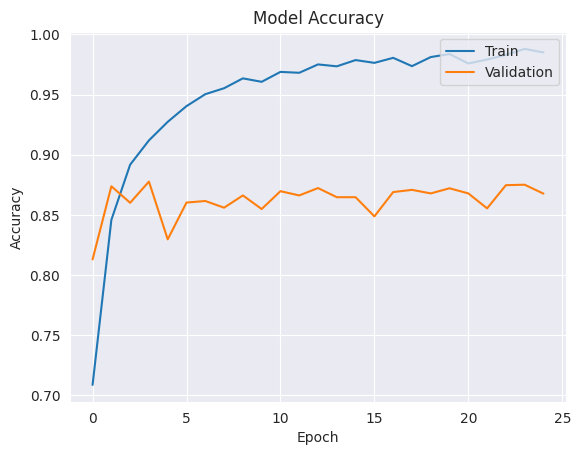

In [52]:
plt.plot(Efficient_history.history['accuracy'])
plt.plot(Efficient_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

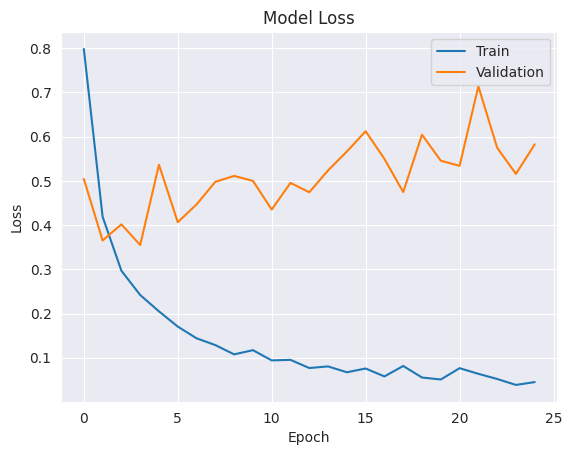

In [53]:
plt.plot(Efficient_history.history['loss'])
plt.plot(Efficient_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()